# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [11]:
#%matplotlib notebook
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import scipy.stats as st
from scipy import fft
import sklearn
import sklearn.ensemble
import emcee
import corner

import george
from george.modeling import ConstantModel as cmodel
from george import kernels

In [2]:
tab = Table.read('KIC2157356.txt',format='ascii')[::10]
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.6753601664968,5220.6865234375,4.893633842468262,6
539.8797024856322,5216.453125,4.8923773765563965,6
540.0840446775328,5217.3818359375,4.894943714141846,6
540.3088210573333,5214.369140625,4.896141529083252,6
540.5131632921839,5222.892578125,4.897199630737305,6
540.7175053997998,5213.36376953125,4.896998882293701,6
540.9218475799353,5224.07080078125,4.8971428871154785,6
541.1466238365683,5210.021484375,4.895411491394043,6


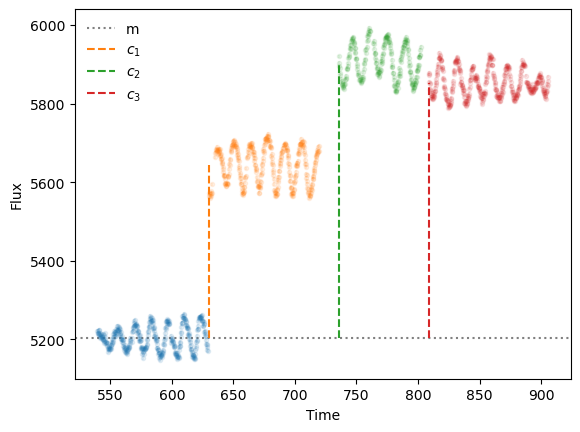

In [3]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.1)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);
plt.show()

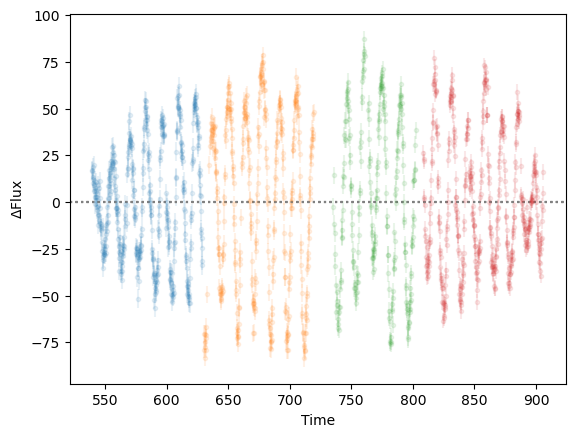

In [4]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    meanflux = np.mean(t['flux'])
    
    plt.errorbar(t['time'],t['flux']-meanflux, yerr=t['error'], marker='.', linestyle='None', alpha=0.1)
    cycle_map[q] = ind
    means.append(meanflux)
    plt.axhline(0, color='grey', ls=":")
    
plt.xlabel('Time')
plt.ylabel('$\Delta$Flux')
#plt.legend(frameon=False)
plt.show()

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [6]:
def kernel(a,gamma,period,lamb):
    return a*kernels.ExpSine2Kernel(gamma=gamma,log_period=period)*kernels.ExpSquaredKernel(metric=lamb/2)

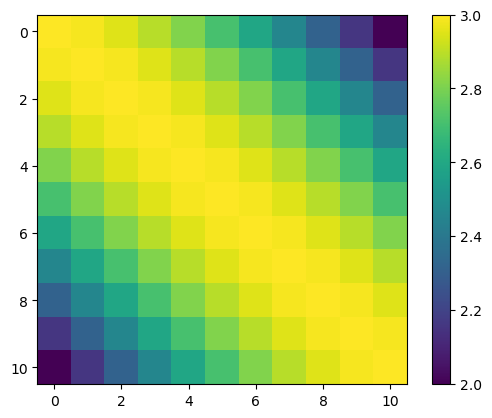

In [209]:
x = np.linspace(0, 1, 11)
kk = kernel(3, 3, 3, 3)

plt.figure()
plt.imshow(kk.get_value(np.atleast_2d(x).T))
plt.colorbar()
plt.show()

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

In [210]:
m_ini = np.mean(tab['flux'][tab['quarter']==6])

In [211]:
gp = george.GP(kernel=kk, mean=cmodel(m_ini))
# gp parameters: (m, a, gamma, period, lambda)

gp.compute(tab['time'],yerr=tab['error'])

In [212]:
def lnprob(p): # p = [m, a, gamma, period, lam, c1, c2, c3]
    gp.set_parameter_vector(p[:5])

    qs = sorted(np.unique(tab['quarter']))[1:]
    normy = tab['flux'].copy()
    for i, q in enumerate(qs):
        normy[tab['quarter']==q] = normy[tab['quarter']==q] - p[-3+i]
    return gp.log_likelihood(normy, quiet=True) + lnprior(p)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

In [213]:
# c1, c2, c3
nuisance_ini = []
qs = sorted(np.unique(tab['quarter']))[1:]
for q in qs:
    nuisance_ini.append(np.mean(tab['flux'][tab['quarter']==q]) - m_ini)
print(nuisance_ini)

[439.20806879622614, 701.8113574924737, 647.6066787086056]


In [214]:
def lnprior(p): # p = [m, a, gamma, period, lam, c1, c2, c3]
    m, a, gamma, period, lam, c1, c2, c3 = p
    
    if m_ini-50<m<m_ini+50 and \
        0<a<10 and \
        0<gamma<5 and \
        period>0 and \
        0<lam<5 and \
        nuisance_ini[0]-50<c1<nuisance_ini[0]+50 and \
        nuisance_ini[1]-50<c2<nuisance_ini[1]+50 and \
        nuisance_ini[2]-50<c3<nuisance_ini[2]+50:
        return np.log(st.norm.pdf(period, loc=15, scale=5))
    else:
        return -np.inf

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [217]:
gp_ini = gp.get_parameter_vector()

nuisance_ini = []
qs = sorted(np.unique(tab['quarter']))[1:]
for q in qs:
    nuisance_ini.append(np.mean(tab['flux'][tab['quarter']==q]) - m_ini)
    
initial = np.concatenate((gp_ini, nuisance_ini))

In [218]:
ndim, nwalkers = len(initial), 20
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 200, progress=True)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 200, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000, progress=True)

Running first burn-in...


100%|█████████████████████████████████████████████████| 200/200 [06:55<00:00,  2.08s/it]


Running second burn-in...


100%|█████████████████████████████████████████████████| 200/200 [06:59<00:00,  2.10s/it]


Running production...


100%|███████████████████████████████████████████████| 1000/1000 [35:09<00:00,  2.11s/it]


State([[5.20735409e+03 7.38217772e+00 3.56325851e+00 1.59169465e+01
  2.14160632e+00 4.35842827e+02 7.08230355e+02 6.44844564e+02]
 [5.21922671e+03 7.52977225e+00 8.23933481e-01 1.04799197e+01
  2.11989079e+00 4.22034494e+02 7.10405134e+02 6.24637721e+02]
 [5.23062552e+03 7.60128587e+00 2.28607540e+00 1.66378450e+01
  2.14307489e+00 4.18712629e+02 6.94610210e+02 6.04055159e+02]
 [5.21024485e+03 7.45696589e+00 4.32564148e+00 8.83892915e+00
  2.07059511e+00 4.24052725e+02 6.92748029e+02 6.47230423e+02]
 [5.21908424e+03 7.55732429e+00 3.19741522e+00 1.49947982e+01
  2.11874433e+00 4.30184398e+02 6.97821347e+02 6.41646610e+02]
 [5.21068530e+03 7.35530130e+00 1.12737772e+00 7.45641360e+00
  1.94276050e+00 4.29674702e+02 7.01404573e+02 6.28243158e+02]
 [5.20264383e+03 7.23195305e+00 1.05665868e+00 8.53320963e+00
  2.02782336e+00 4.29188857e+02 7.10662499e+02 6.68987687e+02]
 [5.19561978e+03 7.68050053e+00 2.68605026e+00 9.61213149e+00
  2.10716229e+00 4.27811244e+02 7.00136488e+02 6.59539231

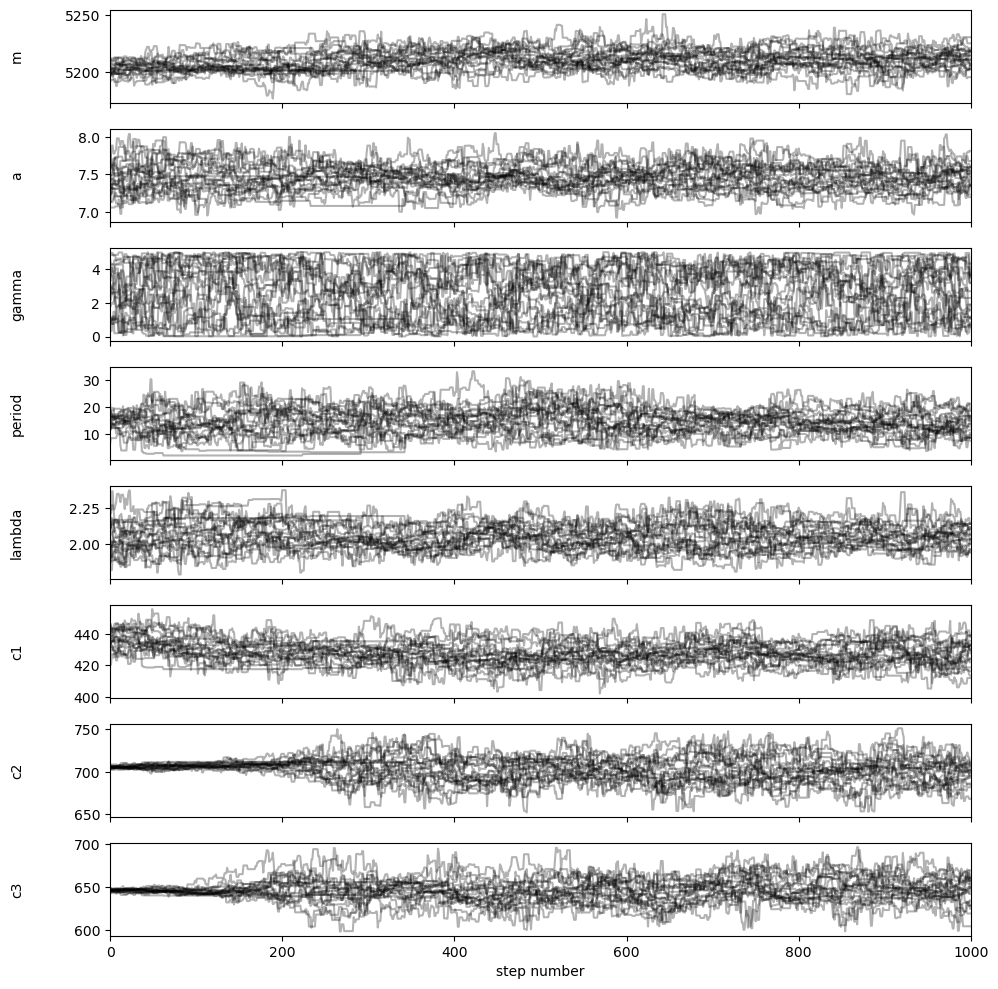

In [219]:
### plotting results
fig, axes = plt.subplots(8, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'a', 'gamma', 'period', 'lambda', 'c1', 'c2', 'c3']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

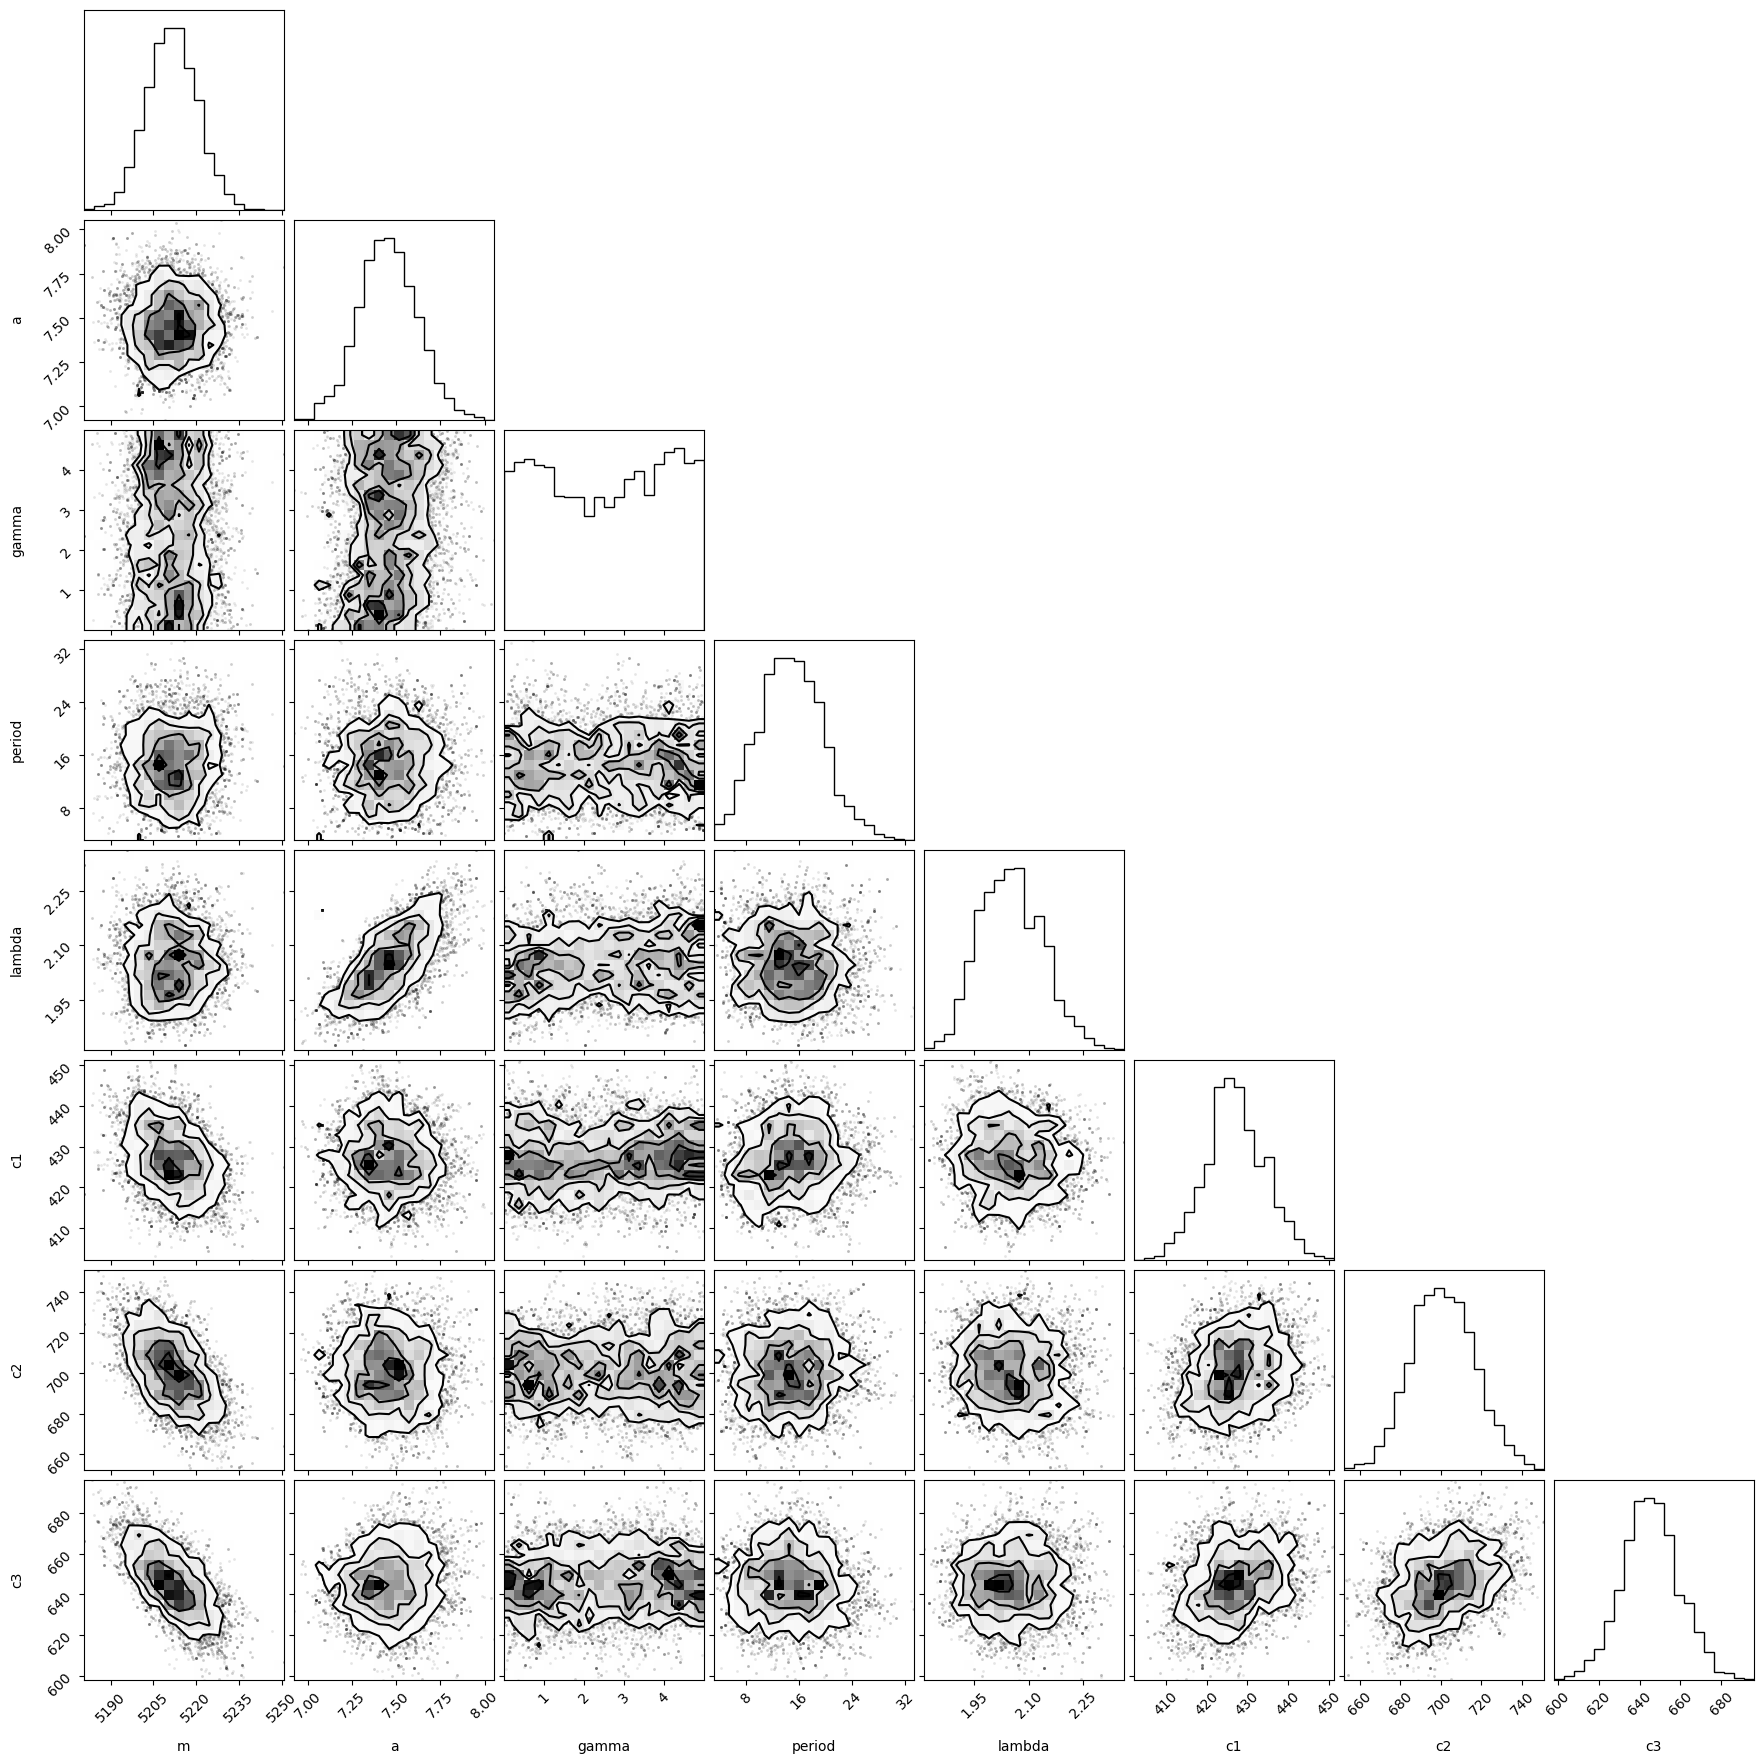

In [223]:
flat_samples = sampler.get_chain(flat=True, discard=300)
corner.corner(flat_samples,labels=labels)
plt.show()

Gamma shows how the data is periodic and because the data was very periodic, I was expecting it to be constrained well.
This is because gamma is a hyperparameter in the kernel so it can't be interpreted physically.
But I am pretty certain that the fitting results are ok because the posterior model fits the data well.

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

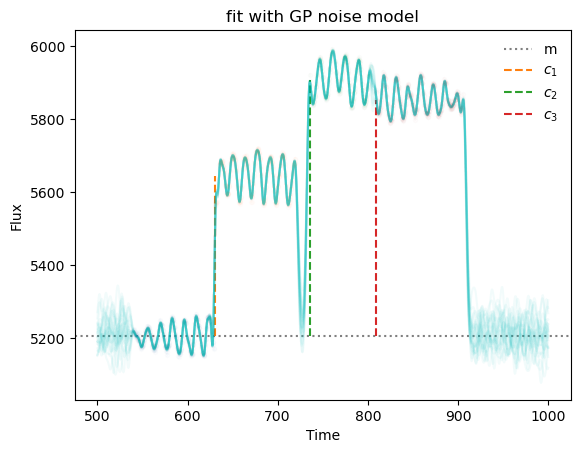

In [224]:
# Plot the data.
qs = [6,7,8,9]
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);

# The positions where the prediction should be computed.
x = np.linspace(500,1000,1001)

# Plot 24 posterior samples.
# samples = sampler.flatchain ######
for s in flat_samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s[:5])
    mu = gp.sample_conditional(tab['flux'], x)
    plt.plot(x, mu, color="c", alpha=0.05)

plt.title("fit with GP noise model");

plt.show()

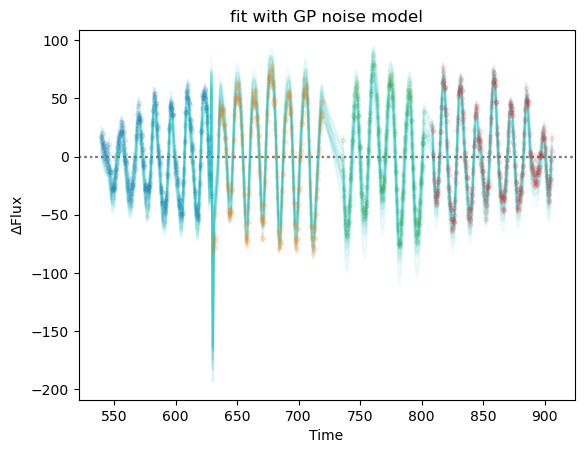

In [225]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    meanflux = np.mean(t['flux'])
    
    plt.errorbar(t['time'],t['flux']-meanflux, yerr=t['error'], marker='.', linestyle='None', alpha=0.1)
    cycle_map[q] = ind
    means.append(meanflux)
    plt.axhline(0, color='grey', ls=":")
    
plt.xlabel('Time')
plt.ylabel('$\Delta$Flux')
#plt.legend(frameon=False)

qs = sorted(np.unique(tab['quarter']))[1:]

# Plot 24 posterior samples.
# samples = sampler.flatchain ######
for s in flat_samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s[:5])
    mu = gp.sample_conditional(tab['flux'], tab['time'])
    
    norm_mu = mu.copy()
    for i, q in enumerate(qs):
        norm_mu[tab['quarter']==q] = norm_mu[tab['quarter']==q] - s[-3+i]
    
    plt.plot(tab['time'], norm_mu-s[0], color="c", alpha=0.05)

plt.title("fit with GP noise model");

plt.show()

The incontinuity in data results in the outlying low point (-200) in the above plot.

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [226]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
pred_cols  = ['bestObjID', 'z', 'zErr', 'zphot', 'dzphot']

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)